In [1]:
#Load all the necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import faiss
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from collections import Counter
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import plot_tree
from imblearn.over_sampling import SMOTE

In [2]:
# Load the dataset
#data = pd.read_csv("creditcard.csv")


path = "dataset.csv.gz"

if os.path.exists(path):
    # Load local file
    data = pd.read_csv(path, compression="gzip")
else:
    # Fallback: download from GitHub (or another URL)
    url = "https://raw.githubusercontent.com/shaikm7d/Credit-Card-Fraud-Detection-with-Machine-Learning/main/dataset.csv.gz"
    data = pd.read_csv(url, compression="gzip")

# Preview the data
print(data.head())
print("Shape of the data:", data.shape)

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [3]:
# Separate features and target, and convert features to float32 for FAISS compatibility
X = data.drop(columns='Class').values.astype('float32')
y = data['Class'].values

#Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

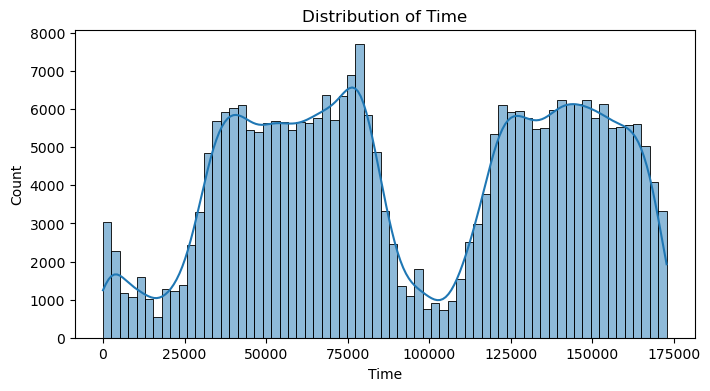

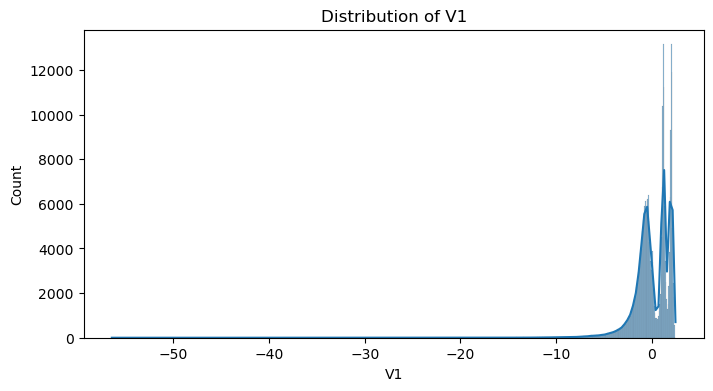

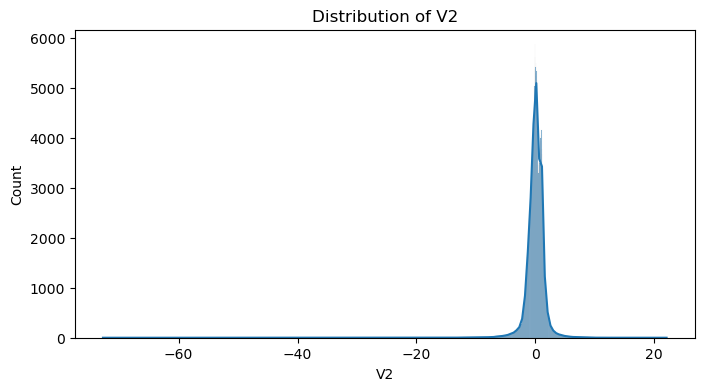

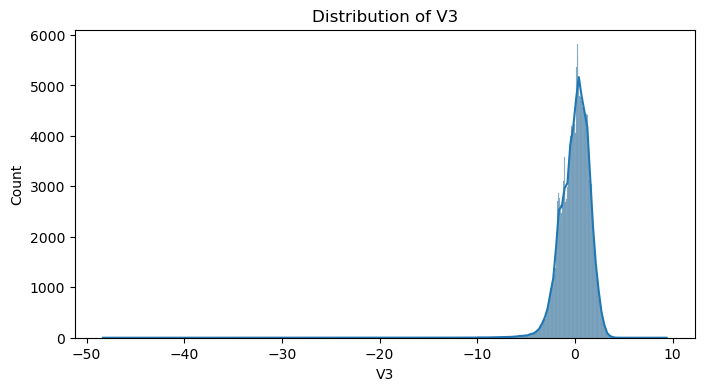

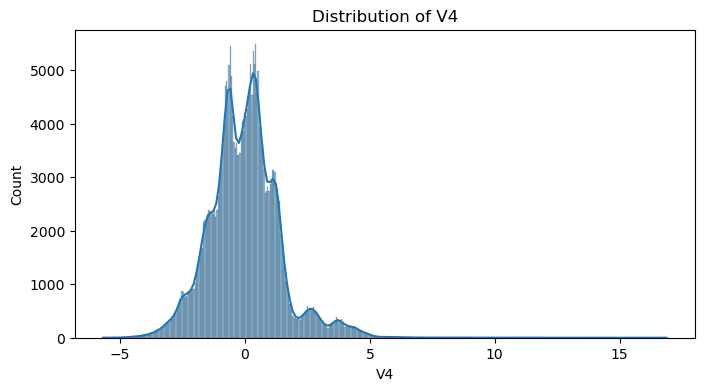

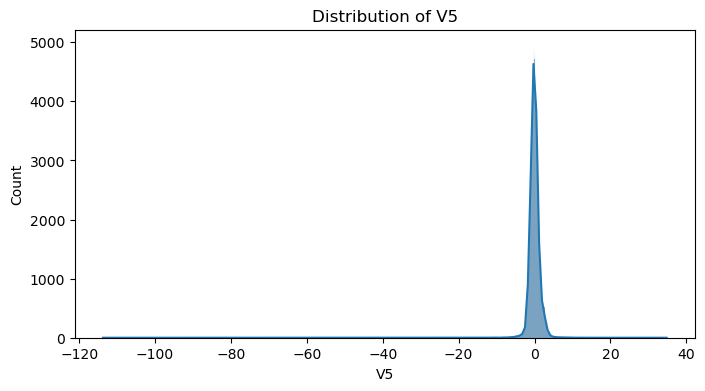

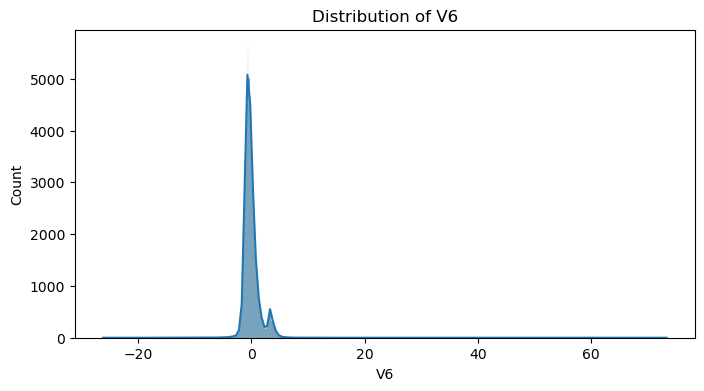

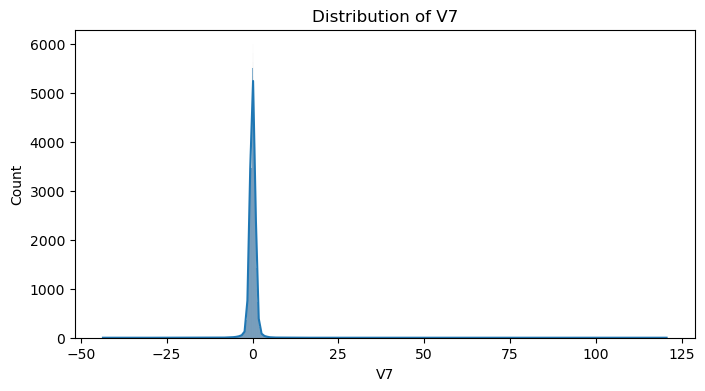

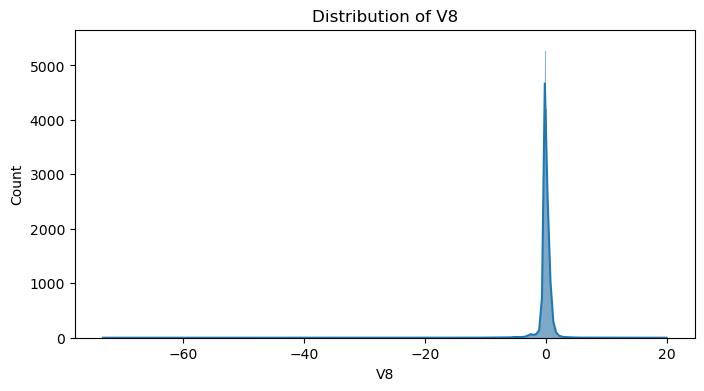

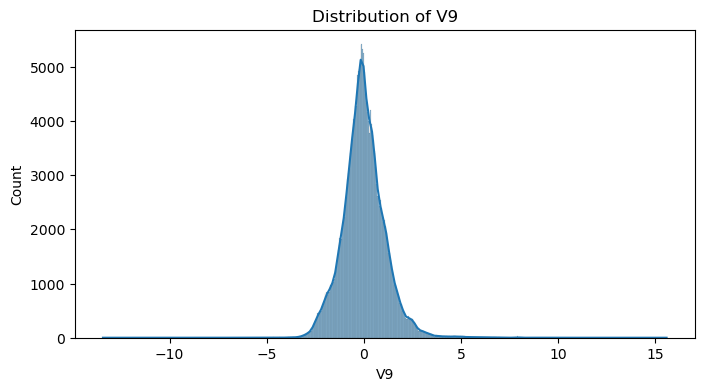

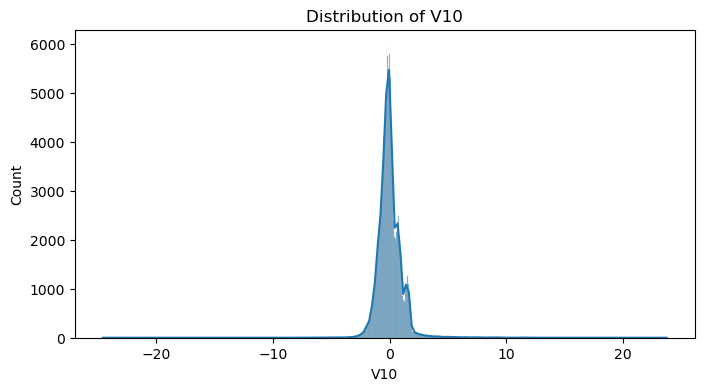

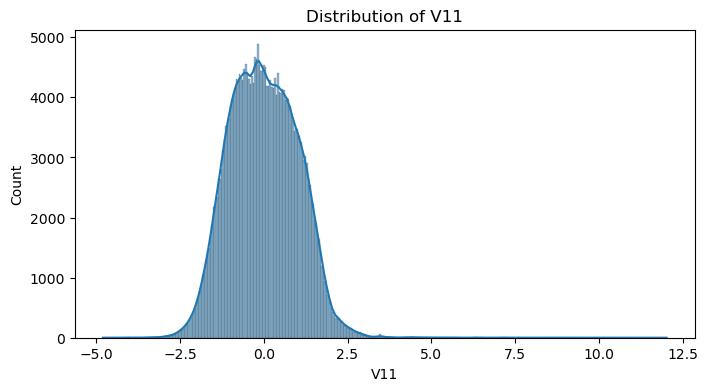

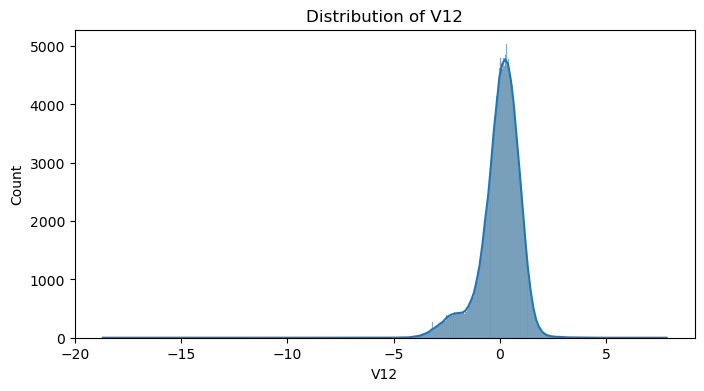

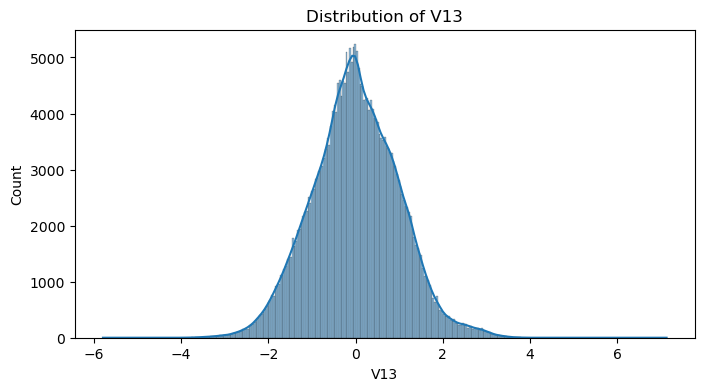

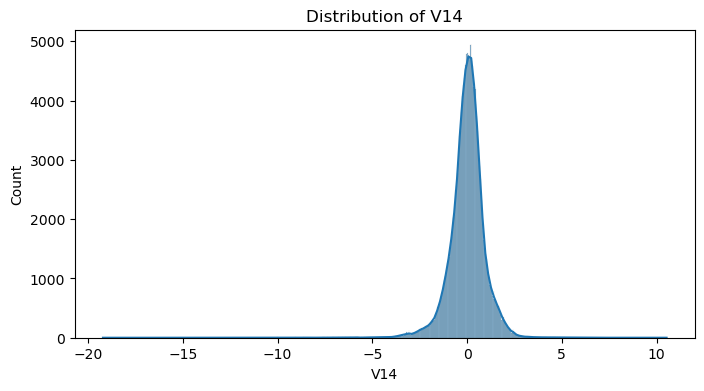

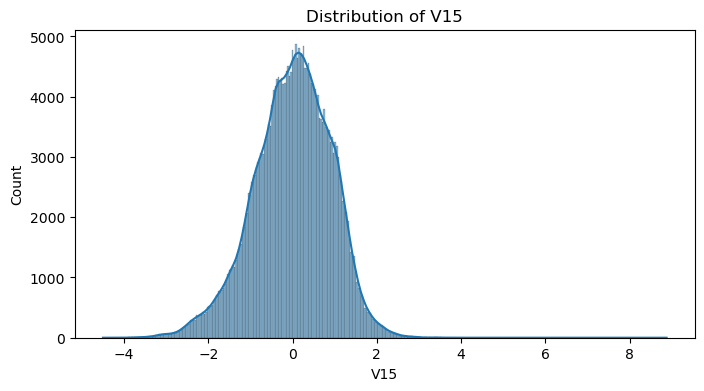

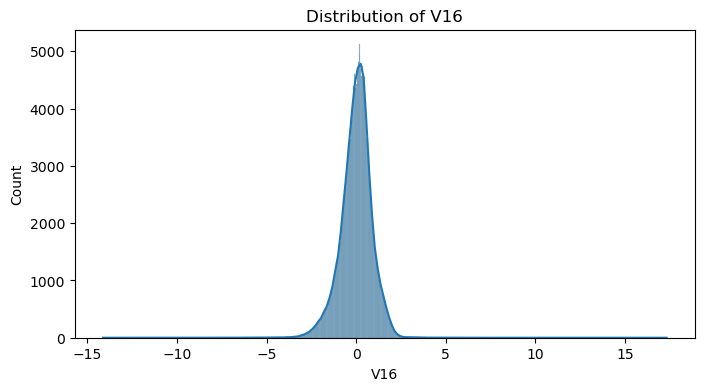

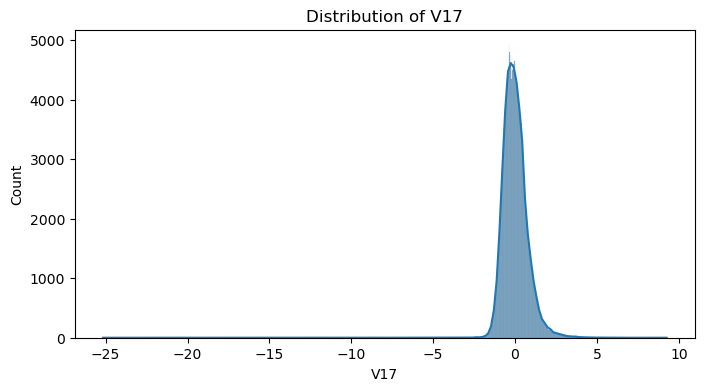

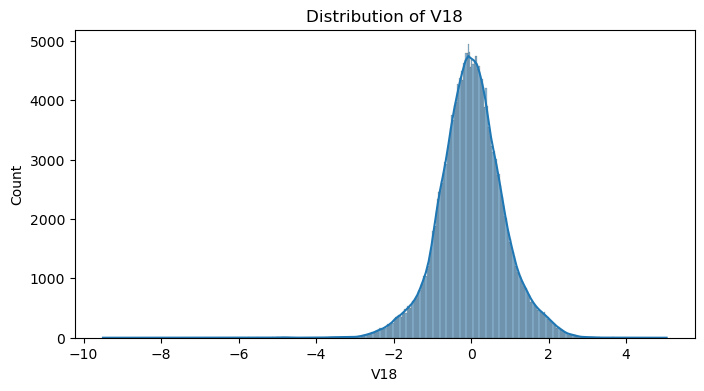

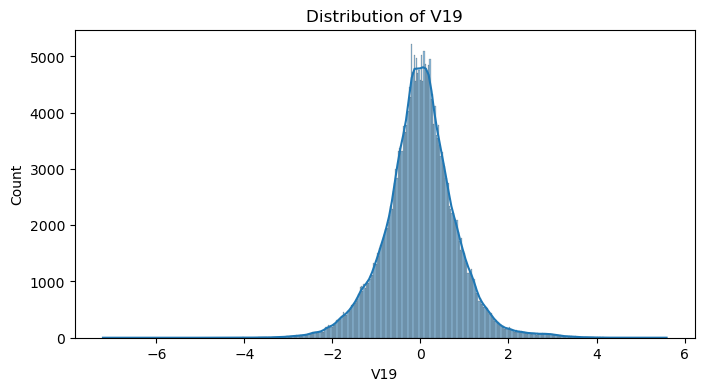

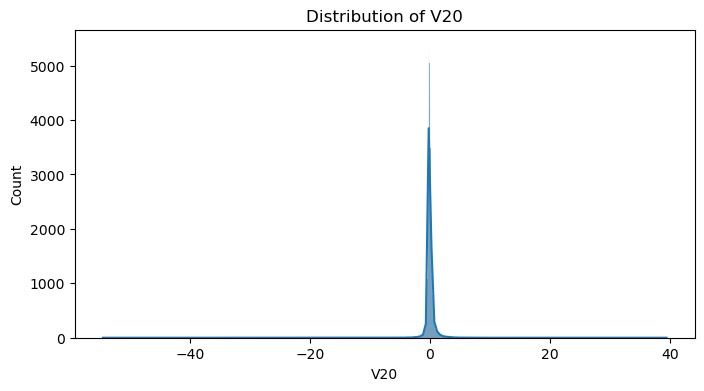

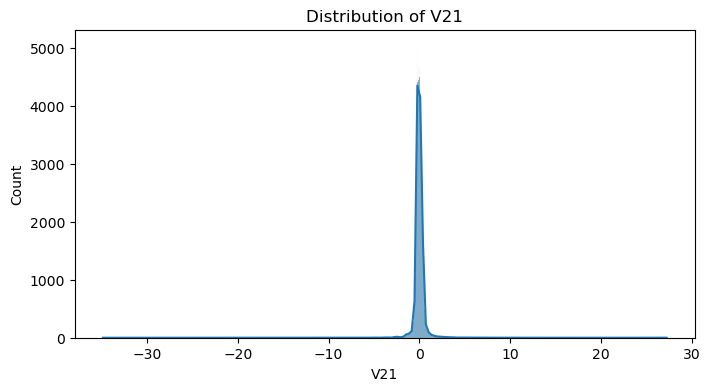

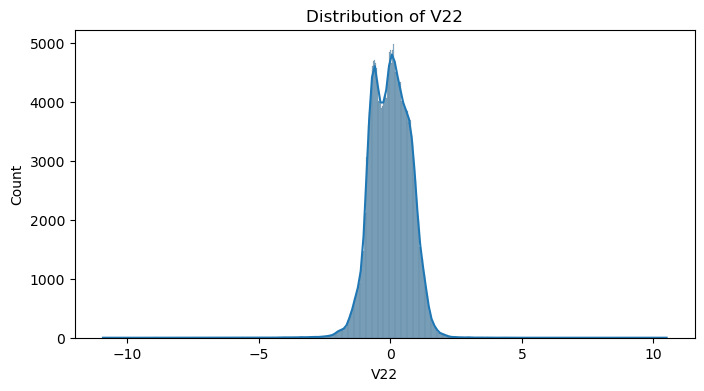

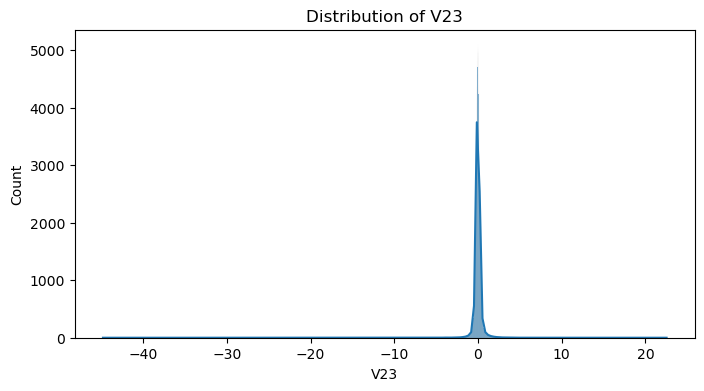

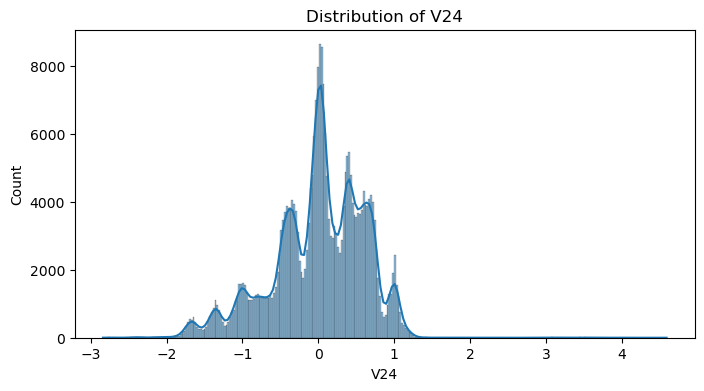

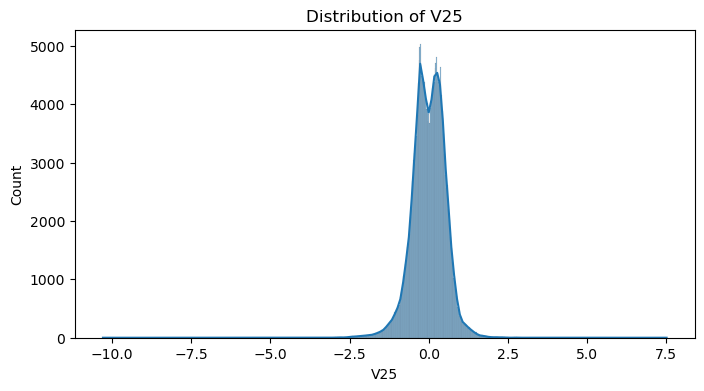

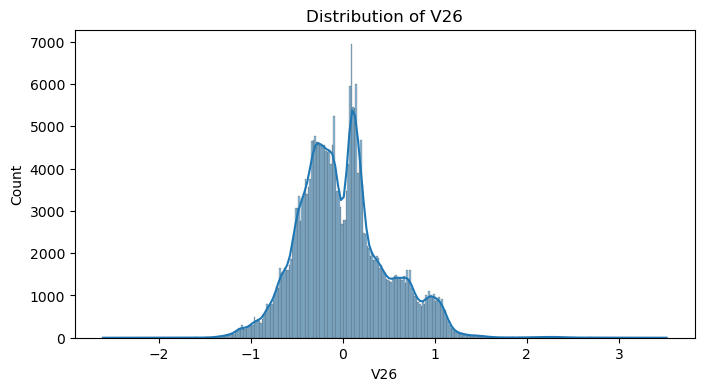

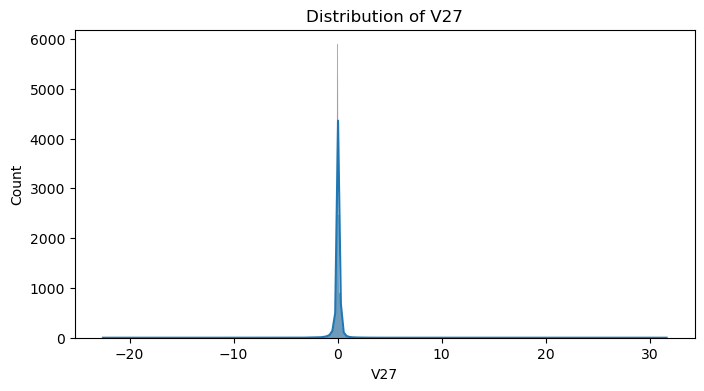

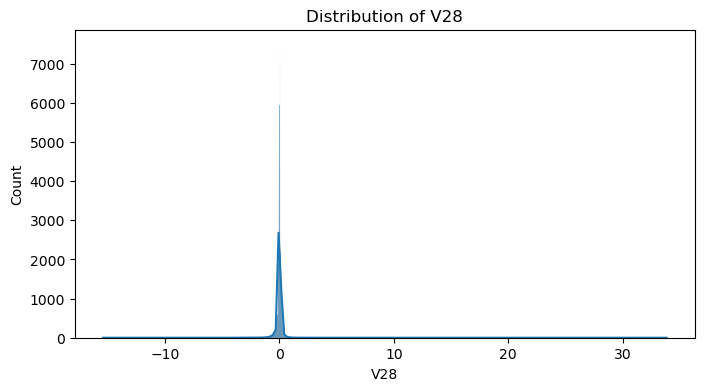

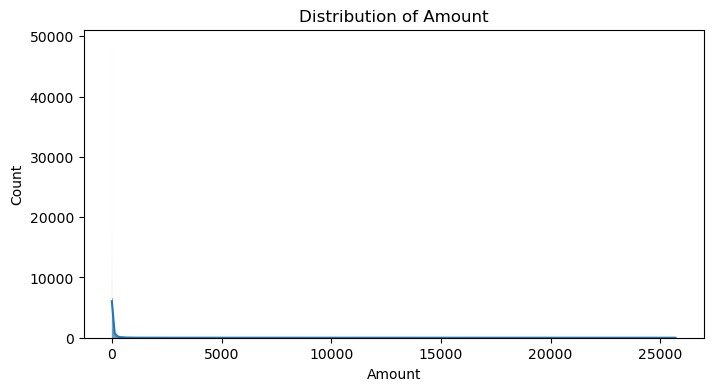

In [12]:
# Select a few features to plot
features_to_plot = ['Time','V1','V2','V3','V4','V5','V6','V7','V8','V9','V10','V11','V12','V13','V14','V15','V16','V17','V18','V19','V20','V21','V22','V23','V24','V25','V26','V27','V28','Amount']

# Plot the distribution for selected features
for feature in features_to_plot:
    plt.figure(figsize=(8, 4))
    sns.histplot(data[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.show()

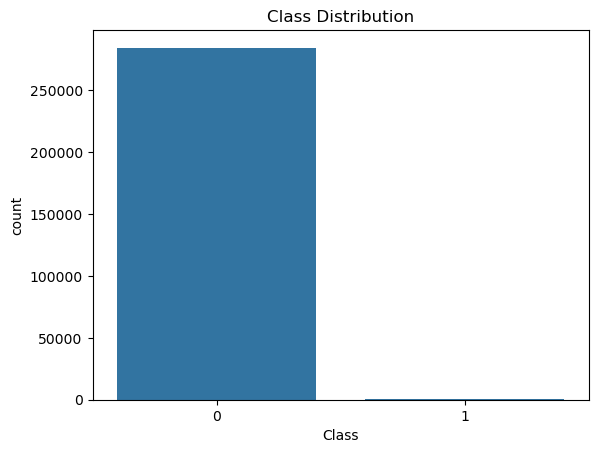

In [13]:
# Plot the count of each class (0 for non-fraud, 1 for fraud)
sns.countplot(x='Class', data=data)
plt.title('Class Distribution')
plt.show()

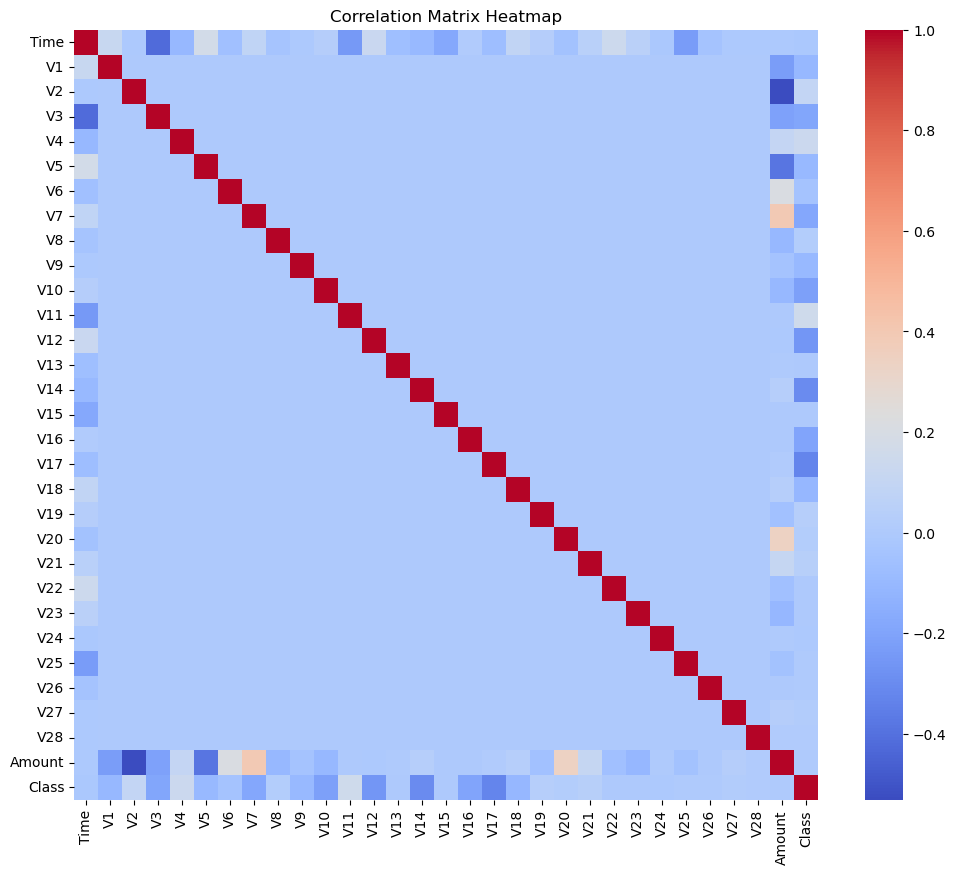

In [14]:
# Plot the correlation matrix
plt.figure(figsize=(12, 10))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [4]:
# Define KNN Functions
def knn_faiss(X_train, y_train, X_test, k):
    """
    Implements KNN using FAISS with GPU support for distance calculation.
    """
    # Create a FAISS index for L2 distance
    index_cpu = faiss.IndexFlatL2(X_train.shape[1])
    
    # Convert to GPU index
    res = faiss.StandardGpuResources()
    index = faiss.index_cpu_to_gpu(res, 0, index_cpu)

    # Add training data to the GPU index
    index.add(X_train)

    # Perform the search: find the k-nearest neighbors for each test point
    distances, indices = index.search(X_test, k)

    # Predict the label for each test point
    predictions = []
    for distances_to_neighbors, neighbors_indices in zip(distances, indices):
        neighbor_labels = y_train[neighbors_indices]
        
        # Weighted majority vote based on inverse distances
        weights = 1 / (distances_to_neighbors + 1e-5)  # Avoid division by zero
        label_votes = Counter()
        for label, weight in zip(neighbor_labels, weights):
            label_votes[label] += weight
        most_common = max(label_votes, key=label_votes.get)
        predictions.append(most_common)

    return np.array(predictions)

def cross_validate_knn(X, y, k_values, cv=10):
    """
    Perform cross-validation to find the best k value for KNN based on F1 score.
    """
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    k_metrics = {k: {'accuracy': [], 'f1': []} for k in k_values}

    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        
    for k in k_values:
        y_pred = knn_faiss(X_train_resampled, y_train_resampled, X_val, k)
        acc = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average='binary')
        k_metrics[k]['accuracy'].append(acc)
        k_metrics[k]['f1'].append(f1)

    # Calculate mean metrics for each k
    mean_metrics = {
        k: {'accuracy': np.mean(metrics['accuracy']), 'f1': np.mean(metrics['f1'])}
        for k, metrics in k_metrics.items()
    }

    # Select the best k based on F1 score
    best_k = max(mean_metrics, key=lambda k: mean_metrics[k]['f1'])

    return best_k, mean_metrics

def evaluate_knn(X_train, y_train, X_test, y_test, best_k):
    """
    Evaluate KNN with the best k on the test set and calculate metrics.
    """
    y_pred = knn_faiss(X_train, y_train, X_test, best_k)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='binary')
    conf_matrix = confusion_matrix(y_test, y_pred)

    return accuracy, f1, conf_matrix

# Perform 10-Fold Cross-Validation to Find the Best k
k_values = [3, 5, 7, 9]
best_k, mean_metrics = cross_validate_knn(X_train_resampled, y_train_resampled, k_values, cv=10)

# Evaluate the Best k on the Test Set
test_accuracy, test_f1, test_conf_matrix = evaluate_knn(X_train_resampled, y_train_resampled, X_test, y_test, best_k)

# Output the Results
print("Best k value (based on F1):", best_k)
print("Cross-validation metrics for each k:", mean_metrics)
print("Test Set Metrics:")
print("Accuracy:", test_accuracy)
print("F1 Score:", test_f1)
print("Confusion Matrix:\n", test_conf_matrix)

Best k value (based on F1): 7
Cross-validation metrics for each k: {3: {'accuracy': 0.8348648054517477, 'f1': 0.8483343428225317}, 5: {'accuracy': 0.8408661244229501, 'f1': 0.8528030256816934}, 7: {'accuracy': 0.8491976258518356, 'f1': 0.8592820512820514}, 9: {'accuracy': 0.8440096724554847, 'f1': 0.853176081109042}}
Test Set Metrics:
Accuracy: 0.7675818967030652
F1 Score: 0.00705017625440636
Confusion Matrix:
 [[43676 13188]
 [   51    47]]


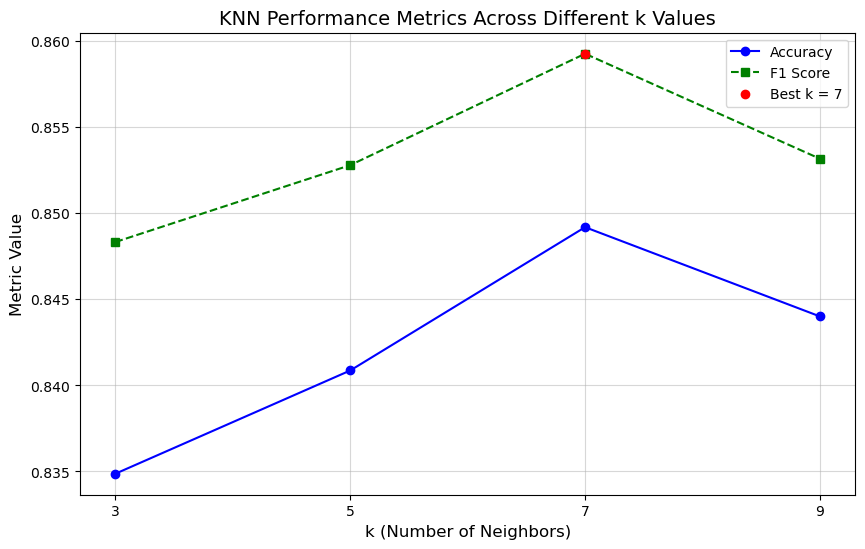

In [6]:
# Visualising various k values in knn
# Extract k values and their corresponding metrics
k_values = list(mean_metrics.keys())
accuracies = [mean_metrics[k]['accuracy'] for k in k_values]
f1_scores = [mean_metrics[k]['f1'] for k in k_values]

# Create a plot for accuracy and F1 score comparison
plt.figure(figsize=(10, 6))

# Plot accuracy
plt.plot(k_values, accuracies, marker='o', linestyle='-', label='Accuracy', color='b')

# Plot F1 score
plt.plot(k_values, f1_scores, marker='s', linestyle='--', label='F1 Score', color='g')

# Highlight the best k value based on F1 score
best_k_idx = k_values.index(best_k)
plt.scatter([best_k], [f1_scores[best_k_idx]], color='red', label=f'Best k = {best_k}', zorder=5)

# Add titles and labels
plt.title("KNN Performance Metrics Across Different k Values", fontsize=14)
plt.xlabel("k (Number of Neighbors)", fontsize=12)
plt.ylabel("Metric Value", fontsize=12)
plt.xticks(k_values)
plt.legend()
plt.grid(alpha=0.5)

# Show the plot
plt.show()

In [5]:
# Define the Decision Tree model
dt = DecisionTreeClassifier(random_state=42, class_weight='balanced')

# Set up parameter grid for max_depth
param_grid = {'max_depth': range(5, 16)}

# Set up GridSearchCV with SMOTE data
grid_search = GridSearchCV(dt, param_grid, cv=10, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best model from GridSearchCV
best_dt = grid_search.best_estimator_

# Predictions and Evaluation on the Test Set
y_pred = best_dt.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Output Results
print("Best max_depth:", grid_search.best_params_['max_depth'])
print("Accuracy of Decision Tree:", accuracy)
print("F1 Score of Decision Tree:", f1)
print("Confusion Matrix:\n", conf_matrix)

Best max_depth: 11
Accuracy of Decision Tree: 0.9895017731118991
F1 Score of Decision Tree: 0.21932114882506526
Confusion Matrix:
 [[56280   584]
 [   14    84]]


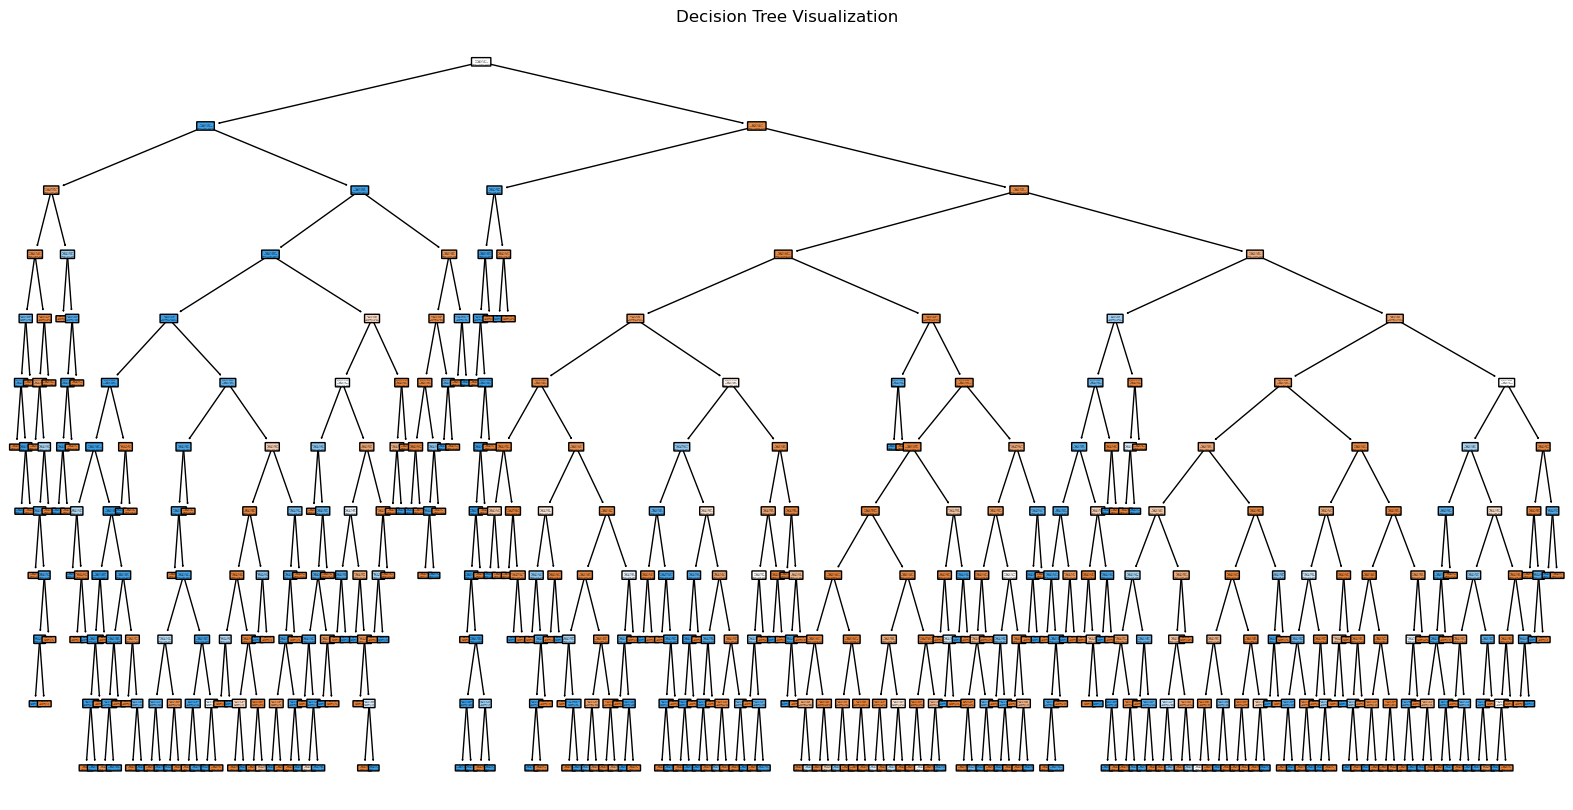

In [7]:
# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(
    best_dt,
    filled=True,
    rounded=True,
    class_names=['Non-Fraud', 'Fraud']
)
plt.title("Decision Tree Visualization")
plt.show()

In [8]:
# Normalize the data (Feature Scaling)
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

In [9]:
# Fitting and hyperarameter tuning on feature scaled data
def cross_validate_knn(X, y, k_values, cv=10):
    """
    Perform cross-validation to find the best k value for KNN based on F1 score.
    """
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    k_metrics = {k: {'accuracy': [], 'f1': []} for k in k_values}

    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Apply SMOTE only to the training data
        smote = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

        # Normalize the data
        scaler = StandardScaler()
        X_train_resampled = scaler.fit_transform(X_train_resampled)
        X_val = scaler.transform(X_val)

        for k in k_values:
            y_pred = knn_faiss(X_train_resampled, y_train_resampled, X_val, k)
            acc = accuracy_score(y_val, y_pred)
            f1 = f1_score(y_val, y_pred, average='binary')
            k_metrics[k]['accuracy'].append(acc)
            k_metrics[k]['f1'].append(f1)

    # Calculate mean metrics for each k
    mean_metrics = {
        k: {'accuracy': np.mean(metrics['accuracy']), 'f1': np.mean(metrics['f1'])}
        for k, metrics in k_metrics.items()
    }

    # Select the best k based on F1 score
    best_k = max(mean_metrics, key=lambda k: mean_metrics[k]['f1'])

    return best_k, mean_metrics

def evaluate_knn(X_train, y_train, X_test, y_test, best_k):
    """
    Evaluate KNN with the best k on the test set and calculate metrics.
    """
    y_pred = knn_faiss(X_train, y_train, X_test, best_k)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='binary')
    conf_matrix = confusion_matrix(y_test, y_pred)

    return accuracy, f1, conf_matrix

# Perform 10-Fold Cross-Validation to Find the Best k
k_values = [3, 5, 7, 9]  # Define the range of k values to test
best_k, mean_metrics = cross_validate_knn(X_train_resampled, y_train_resampled, k_values, cv=10)

# Evaluate the Best k on the Test Set
test_accuracy, test_f1, test_conf_matrix = evaluate_knn(X_train_resampled, y_train_resampled, X_test, y_test, best_k)

# Output the Results
print("Best k value (based on F1):", best_k)
print("Cross-validation metrics for each k:", mean_metrics)
print("Test Set Metrics:")
print("Accuracy:", test_accuracy)
print("F1 Score:", test_f1)
print("Confusion Matrix:\n", test_conf_matrix)


Best k value (based on F1): 3
Cross-validation metrics for each k: {3: {'accuracy': 0.9995515514824861, 'f1': 0.9995517643426698}, 5: {'accuracy': 0.9993471117676043, 'f1': 0.9993475521318931}, 7: {'accuracy': 0.9991514654840137, 'f1': 0.9991522012471974}, 9: {'accuracy': 0.9989514222431595, 'f1': 0.998952542871462}}
Test Set Metrics:
Accuracy: 0.9986657771847899
F1 Score: 0.6779661016949153
Confusion Matrix:
 [[56806    58]
 [   18    80]]


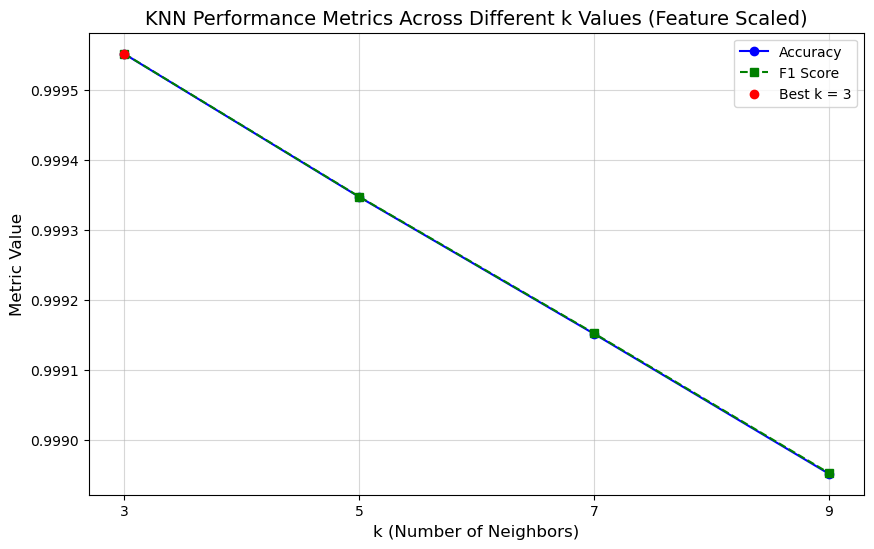

In [10]:
# # Visualising various k values in knn after feature scaling
# Extract k values and their corresponding metrics
k_values = list(mean_metrics.keys())
accuracies = [mean_metrics[k]['accuracy'] for k in k_values]
f1_scores = [mean_metrics[k]['f1'] for k in k_values]

# Create a plot for accuracy and F1 score comparison
plt.figure(figsize=(10, 6))

# Plot accuracy
plt.plot(k_values, accuracies, marker='o', linestyle='-', label='Accuracy', color='b')

# Plot F1 score
plt.plot(k_values, f1_scores, marker='s', linestyle='--', label='F1 Score', color='g')

# Highlight the best k value based on F1 score
best_k_idx = k_values.index(best_k)
plt.scatter([best_k], [f1_scores[best_k_idx]], color='red', label=f'Best k = {best_k}', zorder=5)

# Add titles and labels
plt.title("KNN Performance Metrics Across Different k Values (Feature Scaled)", fontsize=14)
plt.xlabel("k (Number of Neighbors)", fontsize=12)
plt.ylabel("Metric Value", fontsize=12)
plt.xticks(k_values)
plt.legend()
plt.grid(alpha=0.5)

# Show the plot
plt.show()

In [18]:
# Fitting and hyperarameter tuning on feature scaled data
# Set up GridSearchCV with SMOTE data
grid_search = GridSearchCV(dt, param_grid, cv=10, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best model from GridSearchCV
best_dt = grid_search.best_estimator_

# Predictions and Evaluation on the Test Set
y_pred = best_dt.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Output Results
print("Best max_depth:", grid_search.best_params_['max_depth'])
print("Accuracy of Decision Tree:", accuracy)
print("F1 Score of Decision Tree:", f1)
print("Confusion Matrix:\n", conf_matrix)

Best max_depth: 11
Accuracy of Decision Tree: 0.9895017731118991
F1 Score of Decision Tree: 0.21932114882506526
Confusion Matrix:
 [[56280   584]
 [   14    84]]
